# LDA

In [48]:
import pandas as pd
import numpy as np
import os

In [202]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim
import pickle
import os
from gensim import corpora

## Participant-based analysis

### 1.  Dataset: Create the BOW vector from the concatenated strings
### * with BOW

In [491]:
from gensim.models import LdaMulticore, CoherenceModel

# Load and concatenate the DataFrames
def load_and_prepare_data(file_list):
    dfs = [pd.read_json(file, orient='index') for file in file_list]
    df = pd.concat(dfs, axis=1).fillna('')
    df.columns = ['response1', 'response2', 'response3']
    return df

# Preprocess data
def preprocess(df):
    combined_texts = df.apply(lambda row: ' '.join(row), axis=1)
    texts = combined_texts.str.split().tolist()
    return texts, combined_texts

# Train LDA model
def train_lda(corpus, dictionary, num_topics=5, random_state=42):
    lda_model = LdaMulticore(
        corpus=corpus, 
        id2word=dictionary, 
        num_topics=num_topics, 
        passes=10, 
        workers=4, 
        random_state=random_state
    )
    return lda_model

# Compute coherence score
def compute_coherence(lda_model, texts, dictionary):
    cm = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return cm.get_coherence()

In [492]:
# File list
files = [
    '~/thesis/data/processed_uscensus/political_mention1.jsonl',
    '~/thesis/data/processed_uscensus/political_mention2.jsonl',
    '~/thesis/data/processed_uscensus/political_mention3.jsonl'
]

In [493]:
# Main process
df = load_and_prepare_data(files)
texts, combined_texts = preprocess(df)
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [494]:
final_df = df.copy()

index_save = final_df.index 

In [495]:
# Loop to determine the best number of topics
num_topics_range = range(2, 11)  # Example range of topic numbers to try
coherence_scores = []
random_state = 42


### LDA model run below: untoggle the cell. 

In [496]:
for num_topics in num_topics_range:
    lda_model = train_lda(corpus, dictionary, num_topics=num_topics, random_state=random_state)
    coherence_lda = compute_coherence(lda_model, texts, dictionary)
    coherence_scores.append((num_topics, coherence_lda))
    lda_model.save(f'lda_multicore_model_{num_topics}')  # Save model per topic number

In [497]:
# Print coherence scores for each number of topics
for num_topics, coherence_lda in coherence_scores:
    print(f'Num Topics: {num_topics}, Coherence Score: {coherence_lda}')

# Find the best number of topics
best_num_topics, best_coherence_lda = max(coherence_scores, key=lambda item: item[1])
print(f'Best Num Topics: {best_num_topics}, Best Coherence Score: {best_coherence_lda}')

Num Topics: 2, Coherence Score: 0.40394964175020825
Num Topics: 3, Coherence Score: 0.40222968551158295
Num Topics: 4, Coherence Score: 0.41797059168546324
Num Topics: 5, Coherence Score: 0.40307701364662735
Num Topics: 6, Coherence Score: 0.38676374088197335
Num Topics: 7, Coherence Score: 0.38721827470603615
Num Topics: 8, Coherence Score: 0.4026341515357499
Num Topics: 9, Coherence Score: 0.39862267853064076
Num Topics: 10, Coherence Score: 0.3971452506053042
Best Num Topics: 4, Best Coherence Score: 0.41797059168546324


### reload the LDA model

In [498]:
best_num_topics

4

In [266]:
# Reload the best model
best_model_filepath = f'lda_multicore_model_{best_num_topics}'
best_lda_model = LdaMulticore.load(best_model_filepath)

In [267]:
# Step 9: Visualize the LDA Model using PyLDAvis
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/mnt/home/kim/thesis/lda-figure/anes/ldavis_' + str(best_num_topics))

# Prepare the visualization
if not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.gensim.prepare(best_lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

# Save the visualization as an HTML file
html_filepath = '/mnt/home/kim/thesis/lda-figure/anes/ldavis_' + str(best_num_topics) + '.html'
pyLDAvis.save_html(LDAvis_prepared, html_filepath)

# Display the visualization inline (in Jupyter Notebook)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.054600  0.048871       1        1  38.854301
2     -0.036763 -0.055675       2        1  36.190091
0      0.091363  0.006804       3        1  24.955607, topic_info=           Term        Freq        Total Category  logprob  loglift
13       health  700.000000   700.000000  Default  30.0000  30.0000
16       racism  932.000000   932.000000  Default  29.0000  29.0000
126     climate  565.000000   565.000000  Default  28.0000  28.0000
56         need  864.000000   864.000000  Default  27.0000  27.0000
125      change  530.000000   530.000000  Default  26.0000  26.0000
..          ...         ...          ...      ...      ...      ...
26       people  164.529005  2117.982302   Topic3  -5.1927  -1.1671
69   government  125.018796   587.914666   Topic3  -5.4673  -0.1600
332       media  116.299486   535.881253   Topic3  -5.5396  -0.1397
19           19  124.861247  1048.047839   Topic3  -5.4686  -0.7394
46      control  109.701183   521.239303   Topic3  -5.5981  -0.1704

[276 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
19        1  0.162206        19
19        2  0.718479        19
19        3  0.119269        19
67        1  0.787320      able
67        2  0.136469      able
...     ...       ...       ...
1491      1  0.923249  worrying
693       1  0.755273     would
693       2  0.157349     would
693       3  0.088115     would
5552      1  0.898378      zero

[519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

## Connect the demographic information to the LDA results

In [288]:
# extract topic distribution for each document
topic_distributions = [best_lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]
topic_df = pd.DataFrame([{i: prob for i, prob in doc} for doc in topic_distributions]).fillna(0)

In [289]:
# Assign topics to each document
most_probable_topics =  [max(topic, key=lambda x: x[1])[0] for topic in topic_distributions]

In [290]:
community= pd.DataFrame(most_probable_topics, index = index_save, columns = ['community'])

In [291]:
community

,community
200015,0
200022,1
200039,0
200046,2
200053,0
...,...
535414,1
535421,2
535469,1
200411,0


## Demographic dataset

In [292]:
# get the demographcis dataset
demos = pd.read_csv('~/thesis/data/processed_data/anes_demographics.csv')

In [293]:
demos.set_index('id_case', inplace=True)

In [294]:
demos

,POST_vote,POST_president,PRE_present_religion,PRE_age,PRE_education,PRE_race,PRE_sex,PRE_occupation
id_case,,,,,,,,
200015,-1,-1,11,46,4,3,1,1
200022,1,3,12,37,3,4,2,1
200039,1,1,11,40,2,1,2,7
200046,1,1,2,41,3,4,1,1
200053,1,2,12,72,5,5,1,5
...,...,...,...,...,...,...,...,...
535315,-1,-1,11,26,3,1,2,1
535360,1,2,4,52,4,1,2,1
535414,1,1,2,45,2,3,1,1


### filter only the YES vote to the president

In [295]:
demos = demos[demos['POST_vote'] == 1]

In [296]:
demos

,POST_vote,POST_president,PRE_present_religion,PRE_age,PRE_education,PRE_race,PRE_sex,PRE_occupation
id_case,,,,,,,,
200022,1,3,12,37,3,4,2,1
200039,1,1,11,40,2,1,2,7
200046,1,1,2,41,3,4,1,1
200053,1,2,12,72,5,5,1,5
200060,1,1,10,71,3,1,2,5
...,...,...,...,...,...,...,...,...
535292,1,2,11,65,2,1,2,6
535308,1,2,11,54,4,1,2,1
535360,1,2,4,52,4,1,2,1


In [285]:
# Check for duplicate indices 
duplicates = demos.index.duplicated() # no duplicates exist

In [297]:
# Participants_ID converting from integer(index) to the original id from saved index.
final_df.index = index_save 
topic_df.index = index_save

### filter only the indices exist in demos for the clustering

In [298]:
final_df = final_df.loc[final_df.index.isin(demos.index)]
topic_df = topic_df.loc[topic_df.index.isin(demos.index)]
community = community.loc[community.index.isin(demos.index)]

In [299]:
community

,community
200022,1
200039,0
200046,2
200053,0
200060,1
...,...
535292,2
535308,0
535360,1
535414,1


### Make two different dataframe for the analysis: Topic == community 
* merged_df for the topic distributions
* community_df for the topic assignment

In [300]:
# make a common column for the merge
topic_df['id'] = topic_df.index
community['id'] = community.index
demos['id'] = demos.index

# merged_df: for the topic distributions
merged_df = pd.merge(topic_df, demos, on = 'id')
# community_df: for the community label. Here topic == community
community_df = pd.merge(community, demos, on = 'id')

/tmp/ipykernel_2225579/912597800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  community['id'] = community.index
/tmp/ipykernel_2225579/912597800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demos['id'] = demos.index


In [301]:
community_df.index = community_df['id']

In [302]:
community_df

,community,id,POST_vote,POST_president,PRE_present_religion,PRE_age,PRE_education,PRE_race,PRE_sex,PRE_occupation
id,,,,,,,,,,
200022,1,200022,1,3,12,37,3,4,2,1
200039,0,200039,1,1,11,40,2,1,2,7
200046,2,200046,1,1,2,41,3,4,1,1
200053,0,200053,1,2,12,72,5,5,1,5
200060,1,200060,1,1,10,71,3,1,2,5
...,...,...,...,...,...,...,...,...,...,...
535292,2,535292,1,2,11,65,2,1,2,6
535308,0,535308,1,2,11,54,4,1,2,1
535360,1,535360,1,2,4,52,4,1,2,1


In [303]:
# column name changed for the readability 
merged_df = merged_df.rename(columns = {0: 'community0', 1: 'community1', 2: 'community2'})
merged_df.head()

,community0,community1,community2,id,POST_vote,POST_president,PRE_present_religion,PRE_age,PRE_education,PRE_race,PRE_sex,PRE_occupation
0,0.092476,0.797427,0.110096,200022,1,3,12,37,3,4,2,1
1,0.938091,0.030268,0.031640,200039,1,1,11,40,2,1,2,7
2,0.209409,0.037021,0.753570,200046,1,1,2,41,3,4,1,1
3,0.967904,0.014657,0.017439,200053,1,2,12,72,5,5,1,5
4,0.020952,0.537513,0.441535,200060,1,1,10,71,3,1,2,5


### Create the community dictionary

### Age

In [319]:
# Initialize an empty dictionary to store DataFrames
community_dfs_age = {}

# Loop over each community label and create a DataFrame for it
for label in range(best_num_topics):
    community_dfs_age[label] = community_df[community_df['community'] == label][['PRE_age']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_age[0]}")

DataFrame for community 0:
        PRE_age
id             
200039       40
200053       72
200084       37
200275       80
200282       24
...         ...
534640       37
534725       25
534831       80
535100       67
535308       54

[1779 rows x 1 columns]


In [320]:
community_dfs_age

{0:         PRE_age
 id             
 200039       40
 200053       72
 200084       37
 200275       80
 200282       24
 ...         ...
 534640       37
 534725       25
 534831       80
 535100       67
 535308       54
 
 [1779 rows x 1 columns],
 1:         PRE_age
 id             
 200022       37
 200060       71
 200329       73
 200374       50
 200404       41
 ...         ...
 534596       80
 535254       47
 535360       52
 535414       45
 535469       38
 
 [1708 rows x 1 columns],
 2:         PRE_age
 id             
 200046       41
 200114       43
 200121       37
 200138       55
 200152       30
 ...         ...
 534534       49
 534589       58
 534992       46
 535032       68
 535292       65
 
 [2378 rows x 1 columns]}

### Political leaning

In [321]:
# Initialize an empty dictionary to store DataFrames
community_dfs_politics = {}

# Loop over each community label and create a DataFrame for it
for label in range(best_num_topics):
    community_dfs_politics[label] = community_df[community_df['community'] == label][['POST_president']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_politics[0]}")

DataFrame for community 0:
        POST_president
id                    
200039               1
200053               2
200084               2
200275               1
200282               1
...                ...
534640               1
534725               1
534831               1
535100               1
535308               2

[1779 rows x 1 columns]


### Religion

In [322]:
# Initialize an empty dictionary to store DataFrames
community_dfs_religion = {}

# Loop over each community label and create a DataFrame for it
for label in range(best_num_topics):
    community_dfs_religion[label] = community_df[community_df['community'] == label][['PRE_present_religion']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_religion[0]}")

DataFrame for community 0:
        PRE_present_religion
id                          
200039                    11
200053                    12
200084                     1
200275                     2
200282                    10
...                      ...
534640                     9
534725                    12
534831                     1
535100                    12
535308                    11

[1779 rows x 1 columns]


### Education

In [323]:
# Initialize an empty dictionary to store DataFrames
community_dfs_education = {}

# Loop over each community label and create a DataFrame for it
for label in range(best_num_topics):
    community_dfs_education[label] = community_df[community_df['community'] == label][['PRE_education']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_education[0]}")

DataFrame for community 0:
        PRE_education
id                   
200039              2
200053              5
200084              3
200275              1
200282              4
...               ...
534640              3
534725              3
534831              5
535100              1
535308              4

[1779 rows x 1 columns]


### Race

In [324]:
# Initialize an empty dictionary to store DataFrames
community_dfs_race = {}

# Loop over each community label and create a DataFrame for it
for label in range(best_num_topics):
    community_dfs_race[label] = community_df[community_df['community'] == label][['PRE_race']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_race[0]}")

DataFrame for community 0:
        PRE_race
id              
200039         1
200053         5
200084         1
200275         3
200282         1
...          ...
534640         5
534725        -8
534831         1
535100         1
535308         1

[1779 rows x 1 columns]


### Sex

In [325]:
# Initialize an empty dictionary to store DataFrames
community_dfs_sex = {}

# Loop over each community label and create a DataFrame for it
for label in range(best_num_topics):
    community_dfs_sex[label] = community_df[community_df['community'] == label][['PRE_sex']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_sex[0]}")

DataFrame for community 0:
        PRE_sex
id             
200039        2
200053        1
200084        2
200275        2
200282        1
...         ...
534640        1
534725        1
534831        2
535100        1
535308        2

[1779 rows x 1 columns]


### Job

In [326]:
# Initialize an empty dictionary to store DataFrames
community_dfs_job = {}

# Loop over each community label and create a DataFrame for it
for label in range(best_num_topics):
    community_dfs_job[label] = community_df[community_df['community'] == label][['PRE_occupation']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_job[0]}")

DataFrame for community 0:
        PRE_occupation
id                    
200039               7
200053               5
200084               1
200275               5
200282               1
...                ...
534640               1
534725              -2
534831               2
535100               5
535308               1

[1779 rows x 1 columns]


## Statistical Analysis

In [327]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.multivariate.manova as MANOVA

## ANOVA: use the community label

### Age

In [328]:
for label, df_age in community_dfs_age.items():
    print(f"*community_{label} in age")
    print("how many:", len(df_age))
    print("mean:", np.mean(df_age['PRE_age']))
    print("variance:", np.var(df_age['PRE_age']))
    print("std:", np.std(df_age['PRE_age']))
    print()

*community_0 in age
how many: 1779
mean: 47.85553681843732
variance: 401.37036141784057
std: 20.034229743562406

*community_1 in age
how many: 1708
mean: 51.511709601873534
variance: 404.7041954379172
std: 20.11726113162319

*community_2 in age
how many: 2378
mean: 52.45079899074853
variance: 417.68576260803934
std: 20.43736192878228



## Levene's Test

In [329]:
import scipy.stats as stats

In [331]:
# Extract age data from each community's DataFrame
age_groups = [community_dfs_age[label]['PRE_age'].values for label in range(best_num_topics)]

# Perform Levene's test for homogeneity of variances
statistic, p_value = stats.levene(*age_groups)

# Print the results
print("Levene's Test Statistic:", statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of unequal variances.")
else:
    print("Fail to reject the null hypothesis. Variances are likely homogeneous.")

Levene's Test Statistic: 0.7713153071510197
P-value: 0.46245138726680257
Fail to reject the null hypothesis. Variances are likely homogeneous.


## ANOVA

In [332]:
# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*age_groups)

# Print the results
print("ANOVA F-Statistic:", f_statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of significant differences in means.")
else:
    print("Fail to reject the null hypothesis. Means are likely equal across groups.")

ANOVA F-Statistic: 27.821996102661966
P-value: 9.41993377958424e-13
Reject the null hypothesis. There is evidence of significant differences in means.


**Result**: It means, there will be at least one population mean that differs from the rest, and it is not guaranteed that every population group(community) has different mean. 

## Follow-up Analysis on the ANOVA

In [333]:
community_df.head()

,community,id,POST_vote,POST_president,PRE_present_religion,PRE_age,PRE_education,PRE_race,PRE_sex,PRE_occupation
id,,,,,,,,,,
200022,1,200022,1,3,12,37,3,4,2,1
200039,0,200039,1,1,11,40,2,1,2,7
200046,2,200046,1,1,2,41,3,4,1,1
200053,0,200053,1,2,12,72,5,5,1,5
200060,1,200060,1,1,10,71,3,1,2,5


In [334]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=community_df['PRE_age'],
                          groups=community_df['community'],
                          alpha=0.05)

In [335]:
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     0      1   3.6562    0.0 2.0498 5.2626   True
     0      2   4.5953    0.0 3.1088 6.0817   True
     1      2   0.9391 0.3086 -0.565 2.4431  False
--------------------------------------------------


**Result**: 'reject': True means that the means of the two groups are equal is rejected. 
'reject': False means that the means of the two groups are equal is not rejected. 

### Post-hoc analysis: standardized residuals

In [336]:
df_age = community_df[['PRE_age', 'community']]

In [337]:
df_age

,PRE_age,community
id,,
200022,37,1
200039,40,0
200046,41,2
200053,72,0
200060,71,1
...,...,...
535292,65,2
535308,54,0
535360,52,1


In [338]:
# make the dataframe only with the age. 

# Calculate the group means
group_means = df_age.groupby('community')['PRE_age'].mean()

# Calculate residuals for each observation
df_age['residual'] = df_age.apply(lambda row: row['PRE_age'] - group_means[row['community']], axis=1)

# Calculate the standard deviation of the residuals
residual_std = np.std(df_age['residual'], ddof=1)

# Calculate standardized residuals
df_age['standardized_residual'] = df_age['residual'] / residual_std

# Display standardized residuals by group
print("\nStandardized Residuals by Group:")
for group, data in df_age.groupby('community'):
    print(f"\nGroup {group}:")
    print(data[['PRE_age', 'residual', 'standardized_residual']].head())  # Show top few rows for each group

# Summary statistics of standardized residuals by group
print("\nSummary of Standardized Residuals by Group:")
print(df_age.groupby('community')['standardized_residual'].describe())


Standardized Residuals by Group:

Group 0:
        PRE_age   residual  standardized_residual
id                                               
200039       40  -7.855537              -0.388419
200053       72  24.144463               1.193829
200084       37 -10.855537              -0.536755
200275       80  32.144463               1.589391
200282       24 -23.855537              -1.179543

Group 1:
        PRE_age  residual  standardized_residual
id                                              
200022       37 -14.51171              -0.717535
200060       71  19.48829               0.963603
200329       73  21.48829               1.062494
200374       50  -1.51171              -0.074747
200404       41 -10.51171              -0.519754

Group 2:
        PRE_age   residual  standardized_residual
id                                               
200046       41 -11.450799              -0.566187
200114       43  -9.450799              -0.467297
200121       37 -15.450799              -0.

/tmp/ipykernel_2225579/2868037732.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['residual'] = df_age.apply(lambda row: row['PRE_age'] - group_means[row['community']], axis=1)
/tmp/ipykernel_2225579/2868037732.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['standardized_residual'] = df_age['residual'] / residual_std


**Interpretation on the standardized residuals**
* mean: all communities' are centered on 0 as it is standardized. 
* standard deviations(std): Groups with higher value suggests some observations in these groups are more atypical compared to others. Here, the deviations are alike between communities. 
* min and max: The ranges are bigger than expected, it means there are significant variations exist. 

## Chi-Square Test

### First, check the expected frequencies
* It is supposed to be >= 5 every cell in contingency_table.

### Political leaning

In [339]:
combined_df = pd.concat([
    df.assign(community_label = label)
    for label, df in community_dfs_politics.items()
])

In [340]:
combined_df.head()

,POST_president,community_label
id,,
200039,1,0
200053,2,0
200084,2,0
200275,1,0
200282,1,0


In [341]:
# Create a contingency table
contingency_table = pd.crosstab(combined_df['POST_president'], combined_df['community_label'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community_label     0    1     2
POST_president                  
-9                  8   14    26
 1               1279  914  1039
 2                441  729  1251
 3                 17   23    27
 4                  9    8     5
 5                 18   12    24
 7                  0    1     0
 8                  0    3     0
 11                 1    0     1
 12                 6    4     5


### Cut off the dataset

In [342]:
contingency_table.index

Index([-9, 1, 2, 3, 4, 5, 7, 8, 11, 12], dtype='int64', name='POST_president')

In [343]:
# Retain only rows with index 1 and 2
contingency_table_filtered = contingency_table.loc[[1, 2]]

In [344]:
# this is the table with only the people who voted for the Joe Biden/Donald Trump. 
contingency_table_filtered

community_label,0,1,2
POST_president,,,
1,1279,914,1039
2,441,729,1251


In [345]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[ 983.37873695  939.35538652 1309.26587653]
 [ 736.62126305  703.64461348  980.73412347]]
All expected frequencies are >= 5. The Chi-Square test can be used.


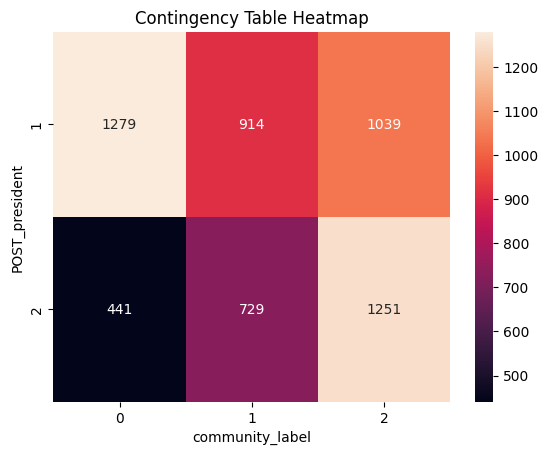

In [346]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table_filtered, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [347]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    339.3743
Degrees of Freedom:       2
p-value:                  2.0221e-74

Expected Frequencies (rounded):
community_label       0       1        2
POST_president                          
1                983.38  939.36  1309.27
2                736.62  703.64   980.73


### Influence of a label on the chi-square test: residuals calculations

In [348]:
# Calculate the residuals
residuals = contingency_table_filtered - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table_filtered.index,
                                         columns=contingency_table_filtered.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    339.3743
Degrees of Freedom:       2
p-value:                  2.0221e-74

Expected Frequencies (rounded):
community_label       0       1        2
POST_president                          
1                983.38  939.36  1309.27
2                736.62  703.64   980.73

Standardized Residuals:
community_label      0     1     2
POST_president                    
1                 9.43 -0.83 -7.47
2               -10.89  0.96  8.63

Extreme Standardized Residuals (|value| > 2):
community_label          0   1         2
POST_president                          
1                 9.427038 NaN -7.469255
2               -10.892148 NaN  8.630095


**Result:**
* The distribution of the feature(**political leaning**) **is significantly different** across different clusters. 
* Extreme Standard residuals exist in all cells except community 1. It means that substantial deviations from expected counts in specific community-label combinations. It highlights where the actual distribution of 'POST_president' significantly differs from what was expected under the null hypothesis. In other words, the variable 'POST_president' is distributed unevenly across the communities, but not in Community 1.  

### Pairwise Comparison with residuals interpretation

In [349]:
import itertools
from statsmodels.stats.multitest import multipletests

In [350]:
# Get all unique pairs of columns (communities)
pairs = list(itertools.combinations(contingency_table_filtered.columns, 2))

# Store results for pairwise comparisons
pairwise_results = []
pairwise_residuals = {}

In [351]:
# Perform pairwise chi-squared tests
for pair in pairs:
    # Create a contingency table for each pair of communities
    pair_table = contingency_table_filtered.loc[:, pair]
    
    # Perform chi-squared test
    chi2_pair, p_pair, dof_pair, expected = stats.chi2_contingency(pair_table)
    
    # Calculate residuals and standardized residuals
    residuals = pair_table - expected
    standardized_residuals = residuals / np.sqrt(expected)
    
    # Append results
    pairwise_results.append((pair, chi2_pair, p_pair))
    pairwise_residuals[pair] = standardized_residuals

In [352]:
# Extract p-values for correction
p_values = [result[2] for result in pairwise_results]

In [353]:
# Apply Bonferroni correction
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

In [354]:
# Print pairwise results with adjusted p-values
print("\nPairwise Chi-Squared Test Results (with Bonferroni correction):")
print("="*65)
print(f"{'Community Pair':<25}{'Chi2':<10}{'p-value':<15}{'Adj. p-value':<15}")
print("-"*65)

for i, (pair, chi2_pair, p_pair) in enumerate(pairwise_results):
    print(f"{str(pair):<25}{chi2_pair:<10.4f}{p_pair:<15.4e}{adjusted_p_values[i]:<15.4e}")


Pairwise Chi-Squared Test Results (with Bonferroni correction):
Community Pair           Chi2      p-value        Adj. p-value   
-----------------------------------------------------------------
(0, 1)                   129.1232  6.3736e-30     1.9121e-29     
(0, 2)                   337.2431  2.5427e-75     7.6280e-75     
(1, 2)                   39.8642   2.7225e-10     8.1674e-10     


* Result: Comparing pairwise, 
    * (0, 1) community: adjusted p-value is <<< 0.05 : signiciant difference
    * (0, 2) community: adjusted p-value is << 0.05 : signiciant difference
    * (1, 2) community: adjusted p-value << 0.05: significant difference 

In [355]:
# Print standardized residuals for each pairwise comparison
print("\nStandardized Residuals for Each Pairwise Comparison:")
for pair, residuals_df in pairwise_residuals.items():
    print(f"\nPair: {pair}")
    print(pd.DataFrame(residuals_df, index=contingency_table_filtered.index, columns=pair).round(2))


Standardized Residuals for Each Pairwise Comparison:

Pair: (0, 1)
                   0     1
POST_president            
1               4.70 -4.81
2              -6.43  6.58

Pair: (0, 2)
                    0     2
POST_president             
1                9.03 -7.83
2              -10.57  9.16

Pair: (1, 2)
                   1     2
POST_president            
1               3.44 -2.91
2              -3.41  2.89


**Interpretation: Residuals**
* Significant deviations from expected frequencies are observed in all pairs but especially the most on (0, 2).  

### Education

In [356]:
combined_df = pd.concat([
    df.assign(community_label = label)
    for label, df in community_dfs_education.items()
])

In [357]:
combined_df.head()

,PRE_education,community_label
id,,
200039,2,0
200053,5,0
200084,3,0
200275,1,0
200282,4,0


In [358]:
# Create a contingency table
contingency_table = pd.crosstab(combined_df['PRE_education'], combined_df['community_label'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community_label    0    1    2
PRE_education                 
-9                 4    4    7
-8                 1    0    0
-2                18   24   30
 1                39   63   54
 2               168  247  345
 3               494  618  854
 4               578  423  615
 5               477  329  473


In [359]:
# this is the table with only the people who voted for the Joe Biden/Donald Trump. 
contingency_table

community_label,0,1,2
PRE_education,,,
-9,4,4,7
-8,1,0,0
-2,18,24,30
1,39,63,54
2,168,247,345
3,494,618,854
4,578,423,615
5,477,329,473


In [360]:
contingency_table_filtered = contingency_table.loc[[-2, 1, 2, 3, 4, 5]]

In [361]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[ 21.83757907  20.97589332  29.18652761]
 [ 47.31475466  45.44776885  63.23747649]
 [230.50777911 221.41220721 308.08001368]
 [596.28722859 572.75842024 796.95435117]
 [490.13233031 470.79227218 655.0753975 ]
 [387.92032826 372.61343819 518.46623354]]
All expected frequencies are >= 5. The Chi-Square test can be used.


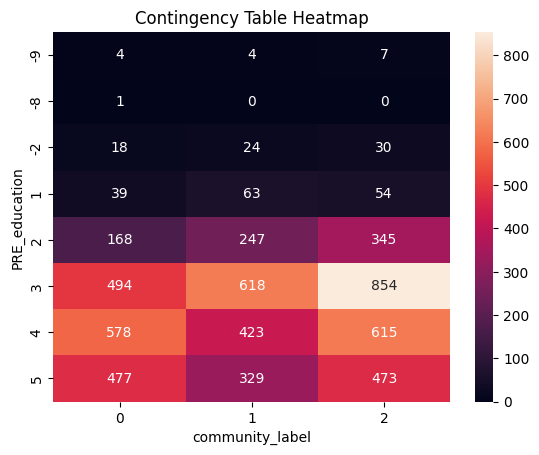

In [362]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [363]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    112.8610
Degrees of Freedom:       10
p-value:                  1.4116e-19

Expected Frequencies (rounded):
community_label       0       1       2
PRE_education                          
-2                21.84   20.98   29.19
 1                47.31   45.45   63.24
 2               230.51  221.41  308.08
 3               596.29  572.76  796.95
 4               490.13  470.79  655.08
 5               387.92  372.61  518.47


**Result**: It says, the educationn shows the significant difference between the clusters

### Influence of a label on the chi-square test: residuals calculations

In [364]:
# Calculate the residuals
residuals = contingency_table_filtered - expected

# bStandardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table_filtered.index,
                                         columns=contingency_table_filtered.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    112.8610
Degrees of Freedom:       10
p-value:                  1.4116e-19

Expected Frequencies (rounded):
community_label       0       1       2
PRE_education                          
-2                21.84   20.98   29.19
 1                47.31   45.45   63.24
 2               230.51  221.41  308.08
 3               596.29  572.76  796.95
 4               490.13  470.79  655.08
 5               387.92  372.61  518.47

Standardized Residuals:
community_label     0     1     2
PRE_education                    
-2              -0.82  0.66  0.15
 1              -1.21  2.60 -1.16
 2              -4.12  1.72  2.10
 3              -4.19  1.89  2.02
 4               3.97 -2.20 -1.57
 5               4.52 -2.26 -2.00

Extreme Standardized Residuals (|value| > 2):
community_label         0         1         2
PRE_education                                
1                     NaN  2.603611       NaN
2               -4.1170

**Result:**
* The distribution of the feature(**education**) **is significantly different** across different clusters. 
* The extreme standardized residuals showed that community 0 is outstandingly different between the communities for its distributions regarding the labels. 

### Pairwise Comparison with residuals interpretation

In [365]:
import itertools
from statsmodels.stats.multitest import multipletests

In [366]:
# Get all unique pairs of columns (communities)
pairs = list(itertools.combinations(contingency_table_filtered.columns, 2))

# Store results for pairwise comparisons
pairwise_results = []
pairwise_residuals = {}

In [367]:
# Perform pairwise chi-squared tests
for pair in pairs:
    # Create a contingency table for each pair of communities
    pair_table = contingency_table_filtered.loc[:, pair]
    
    # Perform chi-squared test
    chi2_pair, p_pair, dof_pair, expected = stats.chi2_contingency(pair_table)
    
    # Calculate residuals and standardized residuals
    residuals = pair_table - expected
    standardized_residuals = residuals / np.sqrt(expected)
    
    # Append results
    pairwise_results.append((pair, chi2_pair, p_pair))
    pairwise_residuals[pair] = standardized_residuals

In [368]:
# Extract p-values for correction
p_values = [result[2] for result in pairwise_results]

In [369]:
# Apply Bonferroni correction
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

In [370]:
# Print pairwise results with adjusted p-values
print("\nPairwise Chi-Squared Test Results (with Bonferroni correction):")
print("="*65)
print(f"{'Community Pair':<25}{'Chi2':<10}{'p-value':<15}{'Adj. p-value':<15}")
print("-"*65)

for i, (pair, chi2_pair, p_pair) in enumerate(pairwise_results):
    print(f"{str(pair):<25}{chi2_pair:<10.4f}{p_pair:<15.4e}{adjusted_p_values[i]:<15.4e}")


Pairwise Chi-Squared Test Results (with Bonferroni correction):
Community Pair           Chi2      p-value        Adj. p-value   
-----------------------------------------------------------------
(0, 1)                   85.1729   6.9249e-17     2.0775e-16     
(0, 2)                   79.4594   1.0888e-15     3.2664e-15     
(1, 2)                   7.8231    1.6626e-01     4.9878e-01     


* Result: Comparing pairwise, 
    * (0, 1) community: adjusted p-value is << 0.05 : signiciant difference
    * (0, 2) community: adjusted p-value is << 0.05 : signiciant difference
    * (1, 2) community: adjusted p-value is > 0.05 : no signiciant difference

In [371]:
# Print standardized residuals for each pairwise comparison
print("\nStandardized Residuals for Each Pairwise Comparison:")
for pair, residuals_df in pairwise_residuals.items():
    print(f"\nPair: {pair}")
    print(pd.DataFrame(residuals_df, index=contingency_table_filtered.index, columns=pair).round(2))


Standardized Residuals for Each Pairwise Comparison:

Pair: (0, 1)
                  0     1
PRE_education            
-2            -0.74  0.75
 1            -1.81  1.84
 2            -3.00  3.06
 3            -3.07  3.14
 4             2.98 -3.04
 5             3.25 -3.32

Pair: (0, 2)
                  0     2
PRE_education            
-2            -0.56  0.49
 1            -0.13  0.11
 2            -3.48  3.01
 3            -3.45  2.99
 4             2.98 -2.58
 5             3.49 -3.02

Pair: (1, 2)
                  1     2
PRE_education            
-2             0.30 -0.25
 1             2.01 -1.71
 2            -0.03  0.03
 3             0.10 -0.08
 4            -0.53  0.45
 5            -0.35  0.29


**Interpretation: Residuals**
* compared to the pair (1, 2), the other pairs show more discrepancies in their distributions as having bigger absolute values of the standardized residuals when comparing between the 2 community. 

### Sex

In [372]:
combined_df = pd.concat([
    df.assign(community_label = label)
    for label, df in community_dfs_sex.items()
])

In [373]:
combined_df.head()

,PRE_sex,community_label
id,,
200039,2,0
200053,1,0
200084,2,0
200275,2,0
200282,1,0


In [374]:
# Create a contingency table
contingency_table = pd.crosstab(combined_df['PRE_sex'], combined_df['community_label'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community_label    0    1     2
PRE_sex                        
-9                14    5    17
 1               793  738  1112
 2               972  965  1249


In [375]:
contingency_table.index

Index([-9, 1, 2], dtype='int64', name='PRE_sex')

In [376]:
contingency_table_filtered = contingency_table.loc[[1, 2]]

In [377]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[ 800.29078744  772.17858981 1070.53062275]
 [ 964.70921256  930.82141019 1290.46937725]]
All expected frequencies are >= 5. The Chi-Square test can be used.


### Chi-Square test

In [378]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    5.8284
Degrees of Freedom:       2
p-value:                  5.4248e-02

Expected Frequencies (rounded):
community_label       0       1        2
PRE_sex                                 
1                800.29  772.18  1070.53
2                964.71  930.82  1290.47


**Result**: It says, the sex shows the significant difference between the clusters

### Influence of a label on the chi-square test: residuals calculations

In [379]:
# Calculate the residuals
residuals = contingency_table_filtered - expected

# bStandardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table_filtered.index,
                                         columns=contingency_table_filtered.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    5.8284
Degrees of Freedom:       2
p-value:                  5.4248e-02

Expected Frequencies (rounded):
community_label       0       1        2
PRE_sex                                 
1                800.29  772.18  1070.53
2                964.71  930.82  1290.47

Standardized Residuals:
community_label     0     1     2
PRE_sex                          
1               -0.26 -1.23  1.27
2                0.23  1.12 -1.15

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


**Result:**
* The distribution of the feature(**sex**) is **not significantly different** across different clusters. 
* The lack of extreme residuals tell that the difference of distributions of the variable is not influenced by a specific cell. 

### Pairwise Comparison with residuals interpretation

In [380]:
import itertools
from statsmodels.stats.multitest import multipletests

In [381]:
# Get all unique pairs of columns (communities)
pairs = list(itertools.combinations(contingency_table_filtered.columns, 2))

# Store results for pairwise comparisons
pairwise_results = []
pairwise_residuals = {}

In [382]:
# Perform pairwise chi-squared tests
for pair in pairs:
    # Create a contingency table for each pair of communities
    pair_table = contingency_table_filtered.loc[:, pair]
    
    # Perform chi-squared test
    chi2_pair, p_pair, dof_pair, expected = stats.chi2_contingency(pair_table)
    
    # Calculate residuals and standardized residuals
    residuals = pair_table - expected
    standardized_residuals = residuals / np.sqrt(expected)
    
    # Append results
    pairwise_results.append((pair, chi2_pair, p_pair))
    pairwise_residuals[pair] = standardized_residuals

In [383]:
# Extract p-values for correction
p_values = [result[2] for result in pairwise_results]

In [384]:
# Apply Bonferroni correction
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

In [385]:
# Print pairwise results with adjusted p-values
print("\nPairwise Chi-Squared Test Results (with Bonferroni correction):")
print("="*65)
print(f"{'Community Pair':<25}{'Chi2':<10}{'p-value':<15}{'Adj. p-value':<15}")
print("-"*65)

for i, (pair, chi2_pair, p_pair) in enumerate(pairwise_results):
    print(f"{str(pair):<25}{chi2_pair:<10.4f}{p_pair:<15.4e}{adjusted_p_values[i]:<15.4e}")


Pairwise Chi-Squared Test Results (with Bonferroni correction):
Community Pair           Chi2      p-value        Adj. p-value   
-----------------------------------------------------------------
(0, 1)                   0.8295    3.6241e-01     1.0000e+00     
(0, 2)                   1.8264    1.7655e-01     5.2966e-01     
(1, 2)                   5.4996    1.9021e-02     5.7062e-02     


* Result: Comparing pairwise, 
    * (0, 1) community: adjusted p-value is > 0.05 : no signiciant difference
    * (0, 2) community: adjusted p-value is > 0.05 : no signiciant difference
    * (1, 2) community: adjusted p-value > 0.05: no significant difference

In [386]:
# Print standardized residuals for each pairwise comparison
print("\nStandardized Residuals for Each Pairwise Comparison:")
for pair, residuals_df in pairwise_residuals.items():
    print(f"\nPair: {pair}")
    print(pd.DataFrame(residuals_df, index=contingency_table_filtered.index, columns=pair).round(2))


Standardized Residuals for Each Pairwise Comparison:

Pair: (0, 1)
            0     1
PRE_sex            
1        0.49 -0.50
2       -0.44  0.45

Pair: (0, 2)
            0     2
PRE_sex            
1       -0.77  0.66
2        0.71 -0.61

Pair: (1, 2)
            1     2
PRE_sex            
1       -1.34  1.14
2        1.22 -1.04


**Interpretation: Residuals**
* compared to the other pair, pair (1, 2) showed the most difference to each other. 

### Employment

In [387]:
combined_df = pd.concat([
    df.assign(community_label = label)
    for label, df in community_dfs_job.items()
])

In [388]:
combined_df.head()

,PRE_occupation,community_label
id,,
200039,7,0
200053,5,0
200084,1,0
200275,5,0
200282,1,0


In [389]:
# Create a contingency table
contingency_table = pd.crosstab(combined_df['PRE_occupation'], combined_df['community_label'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community_label     0     1     2
PRE_occupation                   
-2                  9     6    16
 1               1179  1011  1389
 2                 60    46    64
 4                 31    23    29
 5                342   436   647
 6                 57    74    71
 7                 70    95   144
 8                 31    17    18


In [390]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[   9.40306905    9.02779199   12.56913896]
 [1085.59948849 1042.27314578 1451.12736573]
 [  51.56521739   49.50724638   68.92753623]
 [  25.17595908   24.171185     33.65285592]
 [ 432.23785166  414.98721228  577.77493606]
 [  61.27161125   58.82625746   81.90213129]
 [  93.72736573   89.98670077  125.2859335 ]
 [  20.01943734   19.22046036   26.7601023 ]]
All expected frequencies are >= 5. The Chi-Square test can be used.


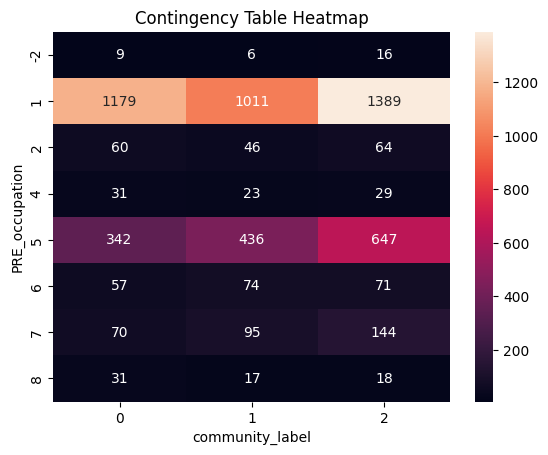

In [391]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [392]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    69.7192
Degrees of Freedom:       14
p-value:                  2.1698e-09

Expected Frequencies (rounded):
community_label        0        1        2
PRE_occupation                            
-2                  9.40     9.03    12.57
 1               1085.60  1042.27  1451.13
 2                 51.57    49.51    68.93
 4                 25.18    24.17    33.65
 5                432.24   414.99   577.77
 6                 61.27    58.83    81.90
 7                 93.73    89.99   125.29
 8                 20.02    19.22    26.76


**Result**: It says, the Employment shows the significant difference between the clusters

### Influence of a label on the chi-square test: residuals calculations

In [393]:
# Calculate the residuals
residuals = contingency_table - expected

# bStandardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table.index,
                                         columns=contingency_table.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    69.7192
Degrees of Freedom:       14
p-value:                  2.1698e-09

Expected Frequencies (rounded):
community_label        0        1        2
PRE_occupation                            
-2                  9.40     9.03    12.57
 1               1085.60  1042.27  1451.13
 2                 51.57    49.51    68.93
 4                 25.18    24.17    33.65
 5                432.24   414.99   577.77
 6                 61.27    58.83    81.90
 7                 93.73    89.99   125.29
 8                 20.02    19.22    26.76

Standardized Residuals:
community_label     0     1     2
PRE_occupation                   
-2              -0.13 -1.01  0.97
 1               2.83 -0.97 -1.63
 2               1.17 -0.50 -0.59
 4               1.16 -0.24 -0.80
 5              -4.34  1.03  2.88
 6              -0.55  1.98 -1.20
 7              -2.45  0.53  1.67
 8               2.45 -0.51 -1.69

Extreme Standardized Residuals

**Result:**
* The distribution of the feature(**Jobs**) **is significantly different** across different clusters. 
* Residuals: needs to be filled

### Pairwise Comparison with residuals interpretation

In [394]:
import itertools
from statsmodels.stats.multitest import multipletests

In [395]:
# Get all unique pairs of columns (communities)
pairs = list(itertools.combinations(contingency_table.columns, 2))

# Store results for pairwise comparisons
pairwise_results = []
pairwise_residuals = {}

In [396]:
# Perform pairwise chi-squared tests
for pair in pairs:
    # Create a contingency table for each pair of communities
    pair_table = contingency_table.loc[:, pair]
    
    # Perform chi-squared test
    chi2_pair, p_pair, dof_pair, expected = stats.chi2_contingency(pair_table)
    
    # Calculate residuals and standardized residuals
    residuals = pair_table - expected
    standardized_residuals = residuals / np.sqrt(expected)
    
    # Append results
    pairwise_results.append((pair, chi2_pair, p_pair))
    pairwise_residuals[pair] = standardized_residuals

In [397]:
# Extract p-values for correction
p_values = [result[2] for result in pairwise_results]

In [398]:
# Apply Bonferroni correction
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

In [399]:
# Print pairwise results with adjusted p-values
print("\nPairwise Chi-Squared Test Results (with Bonferroni correction):")
print("="*65)
print(f"{'Community Pair':<25}{'Chi2':<10}{'p-value':<15}{'Adj. p-value':<15}")
print("-"*65)

for i, (pair, chi2_pair, p_pair) in enumerate(pairwise_results):
    print(f"{str(pair):<25}{chi2_pair:<10.4f}{p_pair:<15.4e}{adjusted_p_values[i]:<15.4e}")


Pairwise Chi-Squared Test Results (with Bonferroni correction):
Community Pair           Chi2      p-value        Adj. p-value   
-----------------------------------------------------------------
(0, 1)                   36.5260   5.7667e-06     1.7300e-05     
(0, 2)                   58.8670   2.5402e-10     7.6207e-10     
(1, 2)                   9.3524    2.2834e-01     6.8502e-01     


* Result: Comparing pairwise, 
    * (0, 1) community: adjusted p-value is needs to be filled. 
    * (0, 2) community: adjusted p-value is needs to be filled. 
    * (1, 2) community: 

In [401]:
# Print standardized residuals for each pairwise comparison
print("\nStandardized Residuals for Each Pairwise Comparison:")
for pair, residuals_df in pairwise_residuals.items():
    print(f"\nPair: {pair}")
    print(pd.DataFrame(residuals_df, index=contingency_table.index, columns=pair).round(2))


Standardized Residuals for Each Pairwise Comparison:

Pair: (0, 1)
                   0     1
PRE_occupation            
-2              0.49 -0.50
 1              1.85 -1.88
 2              0.81 -0.82
 4              0.66 -0.67
 5             -2.76  2.81
 6             -1.20  1.23
 7             -1.55  1.58
 8              1.32 -1.34

Pair: (0, 2)
                   0     2
PRE_occupation            
-2             -0.52  0.45
 1              2.41 -2.09
 2              0.95 -0.82
 4              1.05 -0.91
 5             -3.95  3.42
 6              0.30 -0.26
 7             -2.26  1.95
 8              2.19 -1.89

Pair: (1, 2)
                   1     2
PRE_occupation            
-2             -1.05  0.89
 1              0.25 -0.21
 2              0.00 -0.00
 4              0.27 -0.23
 5             -0.79  0.67
 6              1.72 -1.46
 7             -0.49  0.42
 8              0.62 -0.53


**Interpretation: Residuals**
* Extreme Residuals: needs to be filled
* Moderate Residuals: needs to be filled
* Small Residuals: needs to be filled

### Religion

In [402]:
combined_df = pd.concat([
    df.assign(community_label = label)
    for label, df in community_dfs_religion.items()
])

In [403]:
combined_df.head()

,PRE_present_religion,community_label
id,,
200039,11,0
200053,12,0
200084,1,0
200275,2,0
200282,10,0


In [404]:
# Create a contingency table
contingency_table = pd.crosstab(combined_df['PRE_present_religion'], combined_df['community_label'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community_label         0    1    2
PRE_present_religion               
-9                     12   18   11
 1                    428  461  747
 2                    334  342  521
 3                     34   21   29
 4                     19   30   38
 5                     58   35   49
 6                      9    6    8
 7                     24   10   17
 8                      9    7    9
 9                    111   57   82
 10                   137   91  113
 11                   280  340  406
 12                   324  290  348


In [405]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[ 12.43631714  11.93998295  16.62369991]
 [496.23938619 476.4344416  663.32617221]
 [363.0797954  348.58925831 485.33094629]
 [ 25.47928389  24.46240409  34.05831202]
 [ 26.38925831  25.33606138  35.27468031]
 [ 43.07212276  41.35311168  57.57476556]
 [  6.97647059   6.69803922   9.3254902 ]
 [ 15.46956522  14.85217391  20.67826087]
 [  7.5831202    7.28047741  10.13640239]
 [ 75.83120205  72.80477408 101.36402387]
 [103.43375959  99.30571185 138.26052856]
 [311.2112532  298.79079284 415.99795396]
 [291.79846547 280.15277067 390.04876385]]
All expected frequencies are >= 5. The Chi-Square test can be used.


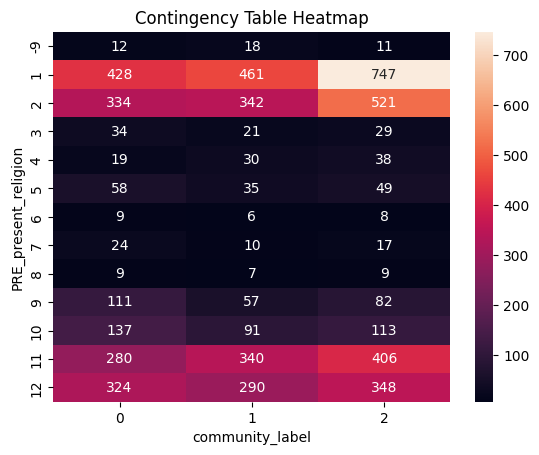

In [406]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [407]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    110.4876
Degrees of Freedom:       24
p-value:                  4.6345e-13

Expected Frequencies (rounded):
community_label            0       1       2
PRE_present_religion                        
-9                     12.44   11.94   16.62
 1                    496.24  476.43  663.33
 2                    363.08  348.59  485.33
 3                     25.48   24.46   34.06
 4                     26.39   25.34   35.27
 5                     43.07   41.35   57.57
 6                      6.98    6.70    9.33
 7                     15.47   14.85   20.68
 8                      7.58    7.28   10.14
 9                     75.83   72.80  101.36
 10                   103.43   99.31  138.26
 11                   311.21  298.79  416.00
 12                   291.80  280.15  390.05


**Result**: It says, the Religion shows the significant difference between the clusters

### Influence of a label on the chi-square test: residuals calculations

In [408]:
# Calculate the residuals
residuals = contingency_table - expected

# bStandardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table.index,
                                         columns=contingency_table.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    110.4876
Degrees of Freedom:       24
p-value:                  4.6345e-13

Expected Frequencies (rounded):
community_label            0       1       2
PRE_present_religion                        
-9                     12.44   11.94   16.62
 1                    496.24  476.43  663.33
 2                    363.08  348.59  485.33
 3                     25.48   24.46   34.06
 4                     26.39   25.34   35.27
 5                     43.07   41.35   57.57
 6                      6.98    6.70    9.33
 7                     15.47   14.85   20.68
 8                      7.58    7.28   10.14
 9                     75.83   72.80  101.36
 10                   103.43   99.31  138.26
 11                   311.21  298.79  416.00
 12                   291.80  280.15  390.05

Standardized Residuals:
community_label          0     1     2
PRE_present_religion                  
-9                   -0.12  1.75 -1.38
 1      

**Result:**
* The distribution of the feature(**religion**) **is significantly different** across different clusters. 
* Residuals: needs to be filled

### Pairwise Comparison with residuals interpretation

In [409]:
import itertools
from statsmodels.stats.multitest import multipletests

In [410]:
# Get all unique pairs of columns (communities)
pairs = list(itertools.combinations(contingency_table.columns, 2))

# Store results for pairwise comparisons
pairwise_results = []
pairwise_residuals = {}

In [411]:
# Perform pairwise chi-squared tests
for pair in pairs:
    # Create a contingency table for each pair of communities
    pair_table = contingency_table.loc[:, pair]
    
    # Perform chi-squared test
    chi2_pair, p_pair, dof_pair, expected = stats.chi2_contingency(pair_table)
    
    # Calculate residuals and standardized residuals
    residuals = pair_table - expected
    standardized_residuals = residuals / np.sqrt(expected)
    
    # Append results
    pairwise_results.append((pair, chi2_pair, p_pair))
    pairwise_residuals[pair] = standardized_residuals

In [412]:
# Extract p-values for correction
p_values = [result[2] for result in pairwise_results]

In [413]:
# Apply Bonferroni correction
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

In [414]:
# Print pairwise results with adjusted p-values
print("\nPairwise Chi-Squared Test Results (with Bonferroni correction):")
print("="*65)
print(f"{'Community Pair':<25}{'Chi2':<10}{'p-value':<15}{'Adj. p-value':<15}")
print("-"*65)

for i, (pair, chi2_pair, p_pair) in enumerate(pairwise_results):
    print(f"{str(pair):<25}{chi2_pair:<10.4f}{p_pair:<15.4e}{adjusted_p_values[i]:<15.4e}")


Pairwise Chi-Squared Test Results (with Bonferroni correction):
Community Pair           Chi2      p-value        Adj. p-value   
-----------------------------------------------------------------
(0, 1)                   53.2681   3.6907e-07     1.1072e-06     
(0, 2)                   82.3479   1.4688e-12     4.4065e-12     
(1, 2)                   22.1474   3.5900e-02     1.0770e-01     


* Result: Comparing pairwise, 
    * (0, 1) community: adjusted p-value is needs to be filled
    * (0, 2) community: adjusted p-value is needs to be filled
    * (1, 2) community: 

In [415]:
# Print standardized residuals for each pairwise comparison
print("\nStandardized Residuals for Each Pairwise Comparison:")
for pair, residuals_df in pairwise_residuals.items():
    print(f"\nPair: {pair}")
    print(pd.DataFrame(residuals_df, index=contingency_table.index, columns=pair).round(2))


Standardized Residuals for Each Pairwise Comparison:

Pair: (0, 1)
                         0     1
PRE_present_religion            
-9                   -0.84  0.86
 1                   -1.20  1.22
 2                   -0.59  0.60
 3                    1.12 -1.14
 4                   -1.20  1.22
 5                    1.53 -1.56
 6                    0.49 -0.50
 7                    1.60 -1.63
 8                    0.29 -0.30
 9                    2.73 -2.79
 10                   1.92 -1.96
 11                  -2.04  2.08
 12                   0.61 -0.62

Pair: (0, 2)
                         0     2
PRE_present_religion            
-9                    0.69 -0.59
 1                   -3.34  2.89
 2                   -1.67  1.44
 3                    1.36 -1.17
 4                   -1.09  0.94
 5                    1.80 -1.56
 6                    0.64 -0.55
 7                    1.54 -1.33
 8                    0.47 -0.40
 9                    3.13 -2.70
 10                   2.90 

**Interpretation: Residuals**
* Extreme Residuals: needs to be filled
* Moderate Residuals: needs to be filled
* Small Residuals: needs to be filled

### 2.  Dataset: Create the tf-idf vector from the concatenated strings
### * with tf-idf

In [450]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [451]:
nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /mnt/home/kim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [464]:
# Load and concatenate the DataFrames
def load_and_prepare_data(file_list):
    dfs = [pd.read_json(file, orient='index') for file in file_list]
    df = pd.concat(dfs, axis=1).fillna('')
    df.columns = ['response1', 'response2', 'response3']
    return df

# Preprocess data
def preprocess(df):
    return df.applymap(lambda x: ' '.join(simple_preprocess(str(x), deacc=True)))

# Tokenize and remove stopwords
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [465]:
# Create TF-IDF vectors
def create_tfidf_vectors(df):
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(df.values.flatten())
    feature_names = vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names, vectorizer

# Sum the vectors per document
def sum_vectors_per_document(tfidf_matrix, df):
    num_docs = df.shape[0]
    summed_vectors = np.zeros((num_docs, tfidf_matrix.shape[1]))

    for i in range(num_docs):
        summed_vectors[i] = tfidf_matrix[i*df.shape[1]:(i+1)*df.shape[1]].sum(axis=0)

    return summed_vectors

# Convert summed vectors to Gensim corpus
def convert_to_gensim_corpus(summed_vectors, feature_names):
    dictionary = Dictionary([feature_names.tolist()])
    corpus = []
    for summed_vec in summed_vectors:
        bow = [(i, summed_vec[i]) for i in range(len(summed_vec)) if summed_vec[i] > 0]
        corpus.append(bow)
    return corpus, dictionary


In [466]:
# Train LDA model
def train_lda(corpus, dictionary, num_topics=5, random_state=42):
    lda_model = LdaMulticore(
        corpus=corpus, 
        id2word=dictionary, 
        num_topics=num_topics, 
        passes=10, 
        workers=4, 
        random_state=random_state
    )
    return lda_model

# Compute coherence score
def compute_coherence(lda_model, texts, dictionary):
    cm = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return cm.get_coherence()



In [467]:
# File list
files = [
    '~/thesis/data/processed_uscensus/political_mention1.jsonl',
    '~/thesis/data/processed_uscensus/political_mention2.jsonl',
    '~/thesis/data/processed_uscensus/political_mention3.jsonl'
]


In [468]:
# Main process
df = load_and_prepare_data(files)

# Pre-process and tokenize data responses
tokenized_responses = preprocess(df)
responses_flat_tokenized = tokenized_responses.values.flatten().tolist()
data_words = list(sent_to_words(responses_flat_tokenized))

In [469]:
# Convert lists of words back into strings for TF-IDF vectorization
merged_data_words_strings = [' '.join(words) for words in data_words]

tfidf_matrix, feature_names, vectorizer = create_tfidf_vectors(tokenized_responses)
summed_vectors = sum_vectors_per_document(tfidf_matrix, tokenized_responses)
corpus, dictionary = convert_to_gensim_corpus(summed_vectors, feature_names)

In [485]:
# Loop to determine the best number of topics
num_topics_range = range(2, 11)  # Example range of topic numbers to try
coherence_scores = []
random_state = 42


In [486]:
for num_topics in num_topics_range:
    lda_model = train_lda(corpus, dictionary, num_topics=num_topics, random_state=random_state)
    coherence_lda = compute_coherence(lda_model, data_words, dictionary)
    coherence_scores.append((num_topics, coherence_lda))
    lda_model.save(f'lda_multicore_model_{num_topics}')  # Save model per topic number


In [487]:
# Print coherence scores for each number of topics
for num_topics, coherence_lda in coherence_scores:
    print(f'Num Topics: {num_topics}, Coherence Score: {coherence_lda}')


Num Topics: 2, Coherence Score: 0.4519950100497997
Num Topics: 3, Coherence Score: 0.4253851282985797
Num Topics: 4, Coherence Score: 0.4508680307515695
Num Topics: 5, Coherence Score: 0.45550156330716945
Num Topics: 6, Coherence Score: 0.46235728882440924
Num Topics: 7, Coherence Score: 0.44491725634748264
Num Topics: 8, Coherence Score: 0.42171667501597343
Num Topics: 9, Coherence Score: 0.45023427690577367
Num Topics: 10, Coherence Score: 0.4326815673534267


In [488]:
# Find the best number of topics
best_num_topics, best_coherence_lda = max(coherence_scores, key=lambda item: item[1])
print(f'Best Num Topics: {best_num_topics}, Best Coherence Score: {best_coherence_lda}')



Best Num Topics: 6, Best Coherence Score: 0.46235728882440924


In [489]:
# Reload the best model
best_model_filepath = f'lda_multicore_model_{best_num_topics}'
best_lda_model = LdaMulticore.load(best_model_filepath)


In [490]:
# Step 9: Visualize the LDA Model using PyLDAvis
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/mnt/home/kim/thesis/lda-figure/anes/ldavis_participant_tfidf' + str(best_num_topics))

# Prepare the visualization
if not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.gensim.prepare(best_lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

# Save the visualization as an HTML file
html_filepath = '/mnt/home/kim/thesis/lda-figure/anes/ldavis_participant_tfidf' + str(best_num_topics) + '.html'
pyLDAvis.save_html(LDAvis_prepared, html_filepath)

# Display the visualization inline (in Jupyter Notebook)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.052649 -0.017086       1        1  28.366344
2      0.166814  0.013500       2        1  17.084983
4     -0.154046 -0.020255       3        1  16.767998
1     -0.034690  0.066813       4        1  15.036447
5     -0.030909  0.069060       5        1  11.762004
3      0.000182 -0.112032       6        1  10.982223, topic_info=         Term        Freq       Total Category  logprob  loglift
713    racism  416.000000  416.000000  Default  30.0000  30.0000
190     covid  861.000000  861.000000  Default  29.0000  29.0000
635  pandemic  455.000000  455.000000  Default  28.0000  28.0000
269   economy  485.000000  485.000000  Default  27.0000  27.0000
405    health  267.000000  267.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
561      many   28.112967  164.948666   Topic6  -4.8674   0.4395
267  economic   25.020293  143.423447   Topic6  -4.9839   0.4628
947     virus   27.173927  208.630254   Topic6  -4.9014   0.1706
658    police   25.686516  229.744628   Topic6  -4.9576   0.0179
713    racism   27.250391  416.025649   Topic6  -4.8985  -0.5168

[398 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5         1  0.097914  acceptance
5         2  0.293742  acceptance
5         4  0.587483  acceptance
5         5  0.097914  acceptance
6         1  0.108484      access
...     ...       ...         ...
992       5  0.070212       would
992       6  0.023404       would
998       1  0.767564       young
998       2  0.069779       young
998       3  0.139557       young

[1315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 6, 4])

## Linkage Matrix

In [124]:
from sklearn.metrics.pairwise import cosine_distances
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [151]:
# Data for the analysis - feature 1000 for each participant_id
final_df

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### 1. Dimensionality reduction for the dendrogram(linkage matrix) visualization

### PCA (Principal Component Analysis)

In [152]:
pca = PCA(n_components = 50)
pca_result = pca.fit_transform(final_df)

In [127]:
distance_matrix = cosine_distances(pca_result)

In [128]:
linkage_matrix = sch.linkage(distance_matrix, method = 'ward')

/tmp/ipykernel_2400999/2685822042.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method = 'ward')


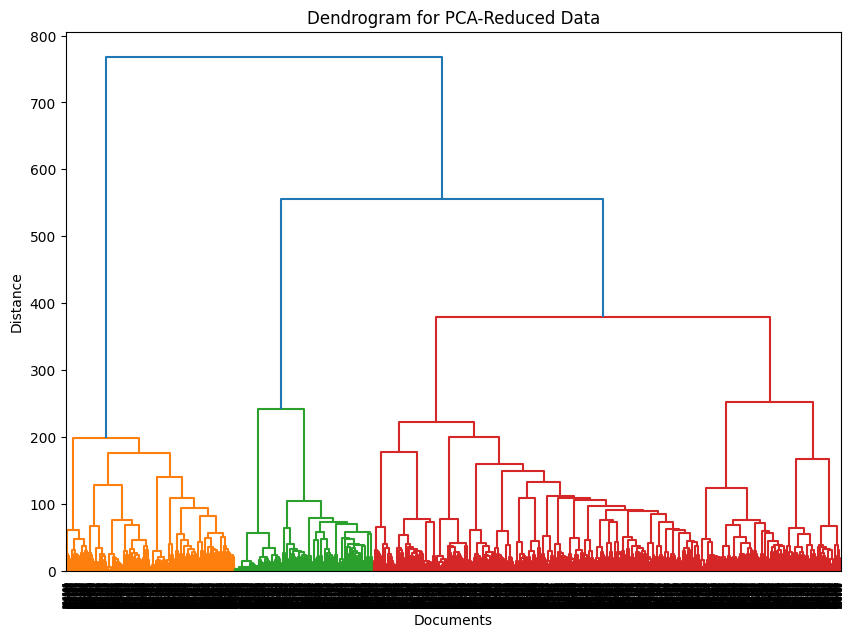

In [129]:
# Step 4: Plot the Dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(linkage_matrix, labels=final_df.index.tolist())
plt.title('Dendrogram for PCA-Reduced Data')
plt.xlabel('Documents')
plt.ylabel('Distance')
plt.show()

### UMAP

In [132]:
import umap

/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/umap/dist

In [148]:
type(final_df)

numpy.ndarray

In [155]:
# change the data type to compatible one to UMAP
from sklearn.preprocessing import StandardScaler

# Example of standardizing data
scaler = StandardScaler()
final_df_scaled = scaler.fit_transform(final_df)
final_df_scaled = final_df_scaled.astype(float)

In [156]:
# initialize the umap model
umap_model = umap.UMAP(n_components = 50, random_state = 42) 
umap_result = umap_model.fit_transform(final_df_scaled)

ValueError: cannot assign slice from input of different size

In [127]:
distance_matrix = cosine_distances(pca_result)

In [128]:
linkage_matrix = sch.linkage(distance_matrix, method = 'ward')

/tmp/ipykernel_2400999/2685822042.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method = 'ward')


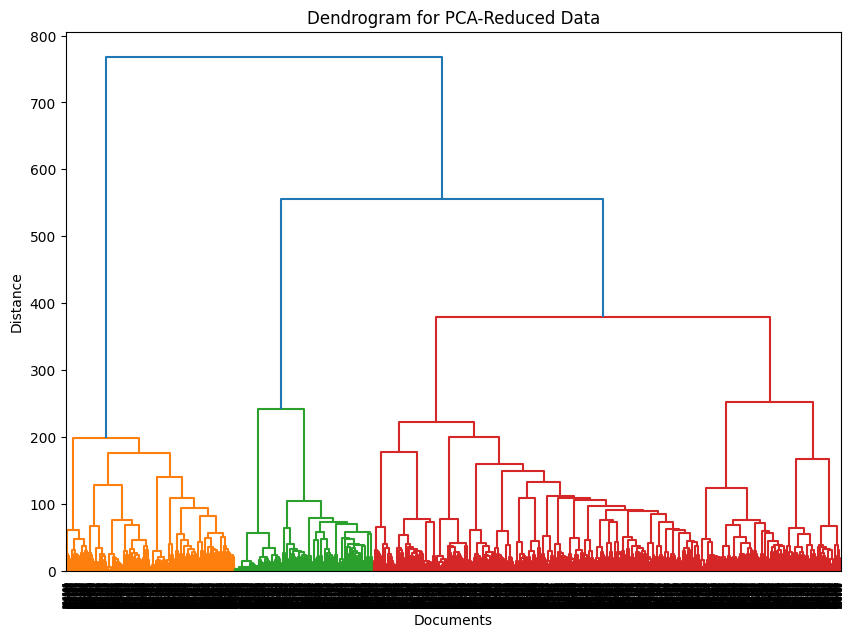

In [129]:
# Step 4: Plot the Dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(linkage_matrix, labels=final_df.index.tolist())
plt.title('Dendrogram for PCA-Reduced Data')
plt.xlabel('Documents')
plt.ylabel('Distance')
plt.show()

### 2. Heatmap instead of the Dendrogram

In [158]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
import scipy.cluster.hierarchy as sch
import seaborn as sns
import matplotlib.pyplot as plt

In [167]:
# Convert DataFrame to numpy array if needed
if isinstance(final_df, pd.DataFrame):
    final_df = final_df.values

# Standardize data
scaler = StandardScaler()
final_df_scaled = scaler.fit_transform(final_df)

In [168]:
# Apply PCA
pca = PCA(n_components=5)  # Reduce to 50 components or adjust as needed
pca_result = pca.fit_transform(final_df_scaled)

In [169]:
# Compute the Distance Matrix
distance_matrix = cosine_distances(pca_result)

# Perform Hierarchical Clustering
linkage_matrix = sch.linkage(distance_matrix, method='ward')


/tmp/ipykernel_2400999/1408223667.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance_matrix, method='ward')


In [170]:
# Create a Cluster Dendrogram
dendro = sch.dendrogram(linkage_matrix, no_plot=True)
dendro_order = dendro['leaves']


In [171]:
# Reorder the distance matrix
distance_matrix_reordered = distance_matrix[np.ix_(dendro_order, dendro_order)]

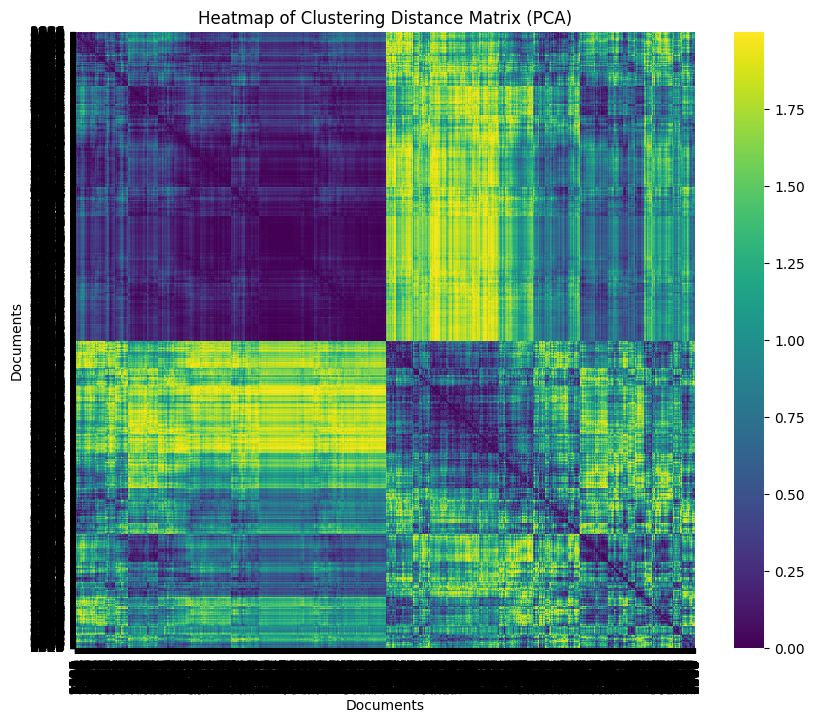

In [172]:
# Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix_reordered, cmap='viridis', cbar=True, 
            xticklabels=np.array(dendro_order)+1, yticklabels=np.array(dendro_order)+1)
plt.title('Heatmap of Clustering Distance Matrix (PCA)')
plt.xlabel('Documents')
plt.ylabel('Documents')
plt.show()


### 2. Dataset: responses stacked
### * with BOW

In [416]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os

In [417]:
# Load data
data = pd.read_json('~/thesis/data/processed_uscensus/political_mentions_stack.jsonl', orient='records', lines=True)

In [418]:
nltk.download('stopwords')

# Set stop words
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /mnt/home/kim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [419]:
# Tokenize and remove stopwords
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [420]:
data = data['stack'].tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['racim', 'blacks', 'whites', 'false', 'information']


In [421]:
# Create dictionary and corpus
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [422]:
# Function to train LDA model and compute coherence score
def train_and_compute_coherence(corpus, dictionary, texts, num_topics, random_state=0):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                             random_state=random_state, chunksize=100, passes=10, alpha=0.01, eta=0.9)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return lda_model, coherence_score


In [423]:
# Determine the best number of topics
num_topics_range = range(2, 11)
coherence_scores = []
random_state = 0


In [425]:
# model saving path
model_path_template = 'lda_multicore_model_{}.model'
ldavis_path_template = '/mnt/home/kim/thesis/lda-figure/anes/ldavis_stack_{}.pkl'

## warning: don't run it, otherwise it will change the result

In [426]:
for num_topics in num_topics_range:
    lda_model, coherence_score = train_and_compute_coherence(corpus, id2word, texts, num_topics, random_state)
    lda_model.save(model_path_template.format(num_topics))  # Saving the model
    coherence_scores.append((num_topics, coherence_score))

In [427]:
# Print coherence scores
for num_topics, score in coherence_scores:
    print(f'Num Topics: {num_topics}, Coherence Score: {score}')

Num Topics: 2, Coherence Score: 0.31098909438858746
Num Topics: 3, Coherence Score: 0.3712881596813955
Num Topics: 4, Coherence Score: 0.4014579657140025
Num Topics: 5, Coherence Score: 0.4260385564073765
Num Topics: 6, Coherence Score: 0.40302215970229643
Num Topics: 7, Coherence Score: 0.35515239337735843
Num Topics: 8, Coherence Score: 0.4100171993514688
Num Topics: 9, Coherence Score: 0.39938415849506304
Num Topics: 10, Coherence Score: 0.4139520293313798


In [428]:
# Find the best number of topics
best_num_topics, best_coherence_score = max(coherence_scores, key=lambda item: item[1])
print(f'Best Num Topics: {best_num_topics}, Best Coherence Score: {best_coherence_score}')

Best Num Topics: 5, Best Coherence Score: 0.4260385564073765


### reload the model that is saved. 

In [429]:
# Reload the best model
best_model_path = model_path_template.format(best_num_topics)
lda_model = LdaMulticore.load(best_model_path)

In [430]:
# Visualize using PyLDAvis
pyLDAvis.enable_notebook()
LDAvis_data_filepath = ldavis_path_template.format(best_num_topics)

if not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

html_filepath = LDAvis_data_filepath.replace('.pkl', '.html')
pyLDAvis.save_html(LDAvis_prepared, html_filepath)


In [431]:
# Display the visualization inline
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.142622  0.015556       1        1  43.455234
2     -0.004182 -0.115925       2        1  18.809387
3     -0.018315 -0.013760       3        1  17.122592
0      0.034441  0.139574       4        1  16.675526
4      0.130678 -0.025446       5        1   3.937261, topic_info=             Term         Freq        Total Category  logprob  loglift
14          covid  1544.000000  1544.000000  Default  30.0000  30.0000
46        economy   865.000000   865.000000  Default  29.0000  29.0000
35         racism   642.000000   642.000000  Default  28.0000  28.0000
15       pandemic   694.000000   694.000000  Default  27.0000  27.0000
102       climate   427.000000   427.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
727   environment     8.329916   102.971702   Topic5  -6.3099   0.7201
3478       moment     5.489973    25.393550   Topic5  -6.7268   1.7031
389         human     5.553874    64.931559   Topic5  -6.7152   0.7758
45       division     5.415490   338.384281   Topic5  -6.7405  -0.9002
2717       allies     5.239060    25.738820   Topic5  -6.7736   1.6428

[302 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
40        1  0.917514   able
40        2  0.022655   able
40        3  0.045309   able
40        4  0.011327   able
40        5  0.011327   able
...     ...       ...    ...
299       5  0.009412  world
408       1  0.897855  would
408       2  0.086460  would
408       3  0.006651  would
408       4  0.006651  would

[1085 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 5])

### 3. Dataset: responses stacked
### * with tf-idf

In [437]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [432]:
# Load data
data = pd.read_json('~/thesis/data/processed_uscensus/political_mentions_stack.jsonl', orient='records', lines=True)

In [433]:
nltk.download('stopwords')

# Set stop words
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /mnt/home/kim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [434]:
# Tokenize and remove stopwords
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = data['stack'].tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['racim', 'blacks', 'whites', 'false', 'information']


In [435]:
# Flatten the tokenized words back into strings
data_words_strings = [' '.join(words) for words in data_words]

In [438]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit the vectorizer and transform the documents
X_tfidf = vectorizer.fit_transform(data_words_strings)

# Get the feature names (i.e., words) and create a mapping for Gensim
feature_names = vectorizer.get_feature_names_out()
id2word = Dictionary([feature_names.tolist()])


In [439]:
# Convert the TF-IDF matrix to a Gensim-compatible corpus format
corpus = []
for doc in X_tfidf:
    doc_tuples = list(enumerate(doc.toarray()[0]))
    doc_tuples = [(i, val) for i, val in doc_tuples if val > 0]
    corpus.append(doc_tuples)

In [440]:
# View the first document's first 30 tokens
print(corpus[:1][0][:30])

[(94, 0.5983382896851441), (323, 0.581845018098146), (465, 0.5508608408763729)]


In [441]:
# Function to train LDA model and compute coherence score
def train_and_compute_coherence(corpus, dictionary, texts, num_topics, random_state=0):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                             random_state=random_state, chunksize=100, passes=10, alpha=0.01, eta=0.9)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return lda_model, coherence_score


In [442]:
# Determine the best number of topics
num_topics_range = range(2, 11)
coherence_scores = []
random_state = 0


### warning: don't run it, otherwise it will rewrite. 

In [443]:
# save the path and reload it later
model_path_template = 'lda_multicore_model_{}.model'
ldavis_path_template = '/mnt/home/kim/thesis/lda-figure/anes/ldavis_{}.pkl'

In [444]:
for num_topics in num_topics_range:
    lda_model, coherence_score = train_and_compute_coherence(corpus, id2word, data_words, num_topics, random_state)
    lda_model.save(model_path_template.format(num_topics))
    coherence_scores.append((num_topics, coherence_score))


In [445]:
# Print coherence scores
for num_topics, score in coherence_scores:
    print(f'Num Topics: {num_topics}, Coherence Score: {score}')


Num Topics: 2, Coherence Score: 0.26868235684808206
Num Topics: 3, Coherence Score: 0.3790876689072166
Num Topics: 4, Coherence Score: 0.35250292497453994
Num Topics: 5, Coherence Score: 0.415668478147424
Num Topics: 6, Coherence Score: 0.35625961057144173
Num Topics: 7, Coherence Score: 0.40345964633918946
Num Topics: 8, Coherence Score: 0.38645108697397357
Num Topics: 9, Coherence Score: 0.40429485071403826
Num Topics: 10, Coherence Score: 0.40328194336484147


In [446]:
# Find the best number of topics
best_num_topics, best_coherence_score = max(coherence_scores, key=lambda item: item[1])
print(f'Best Num Topics: {best_num_topics}, Best Coherence Score: {best_coherence_score}')


Best Num Topics: 5, Best Coherence Score: 0.415668478147424


### reload the LDA model from here

In [447]:
# Reload the best model
best_model_path = model_path_template.format(best_num_topics)
lda_model = LdaMulticore.load(best_model_path)

In [448]:
# Visualize using PyLDAvis
pyLDAvis.enable_notebook()
LDAvis_data_filepath = ldavis_path_template.format(best_num_topics)

if not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

html_filepath = LDAvis_data_filepath.replace('.pkl', '.html')
pyLDAvis.save_html(LDAvis_prepared, html_filepath)

In [449]:
# Display the visualization inline
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.043111 -0.102489       1        1  29.749500
2     -0.004620 -0.054680       2        1  18.948122
1     -0.169083  0.105464       3        1  18.771122
0      0.149215  0.118430       4        1  17.464122
3      0.067599 -0.066724       5        1  15.067134, topic_info=         Term        Freq       Total Category  logprob  loglift
190     covid  686.000000  686.000000  Default  30.0000  30.0000
269   economy  441.000000  441.000000  Default  29.0000  29.0000
635  pandemic  368.000000  368.000000  Default  28.0000  28.0000
713    racism  353.000000  353.000000  Default  27.0000  27.0000
405    health  231.000000  231.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
478    issues   33.072919  111.253100   Topic5  -5.0197   0.6796
492      lack   39.308762  216.665952   Topic5  -4.8469   0.1857
267  economic   28.572970  138.027841   Topic5  -5.1659   0.3177
171   control   27.696674  181.165541   Topic5  -5.1971   0.0146
595      much   26.103478  108.182500   Topic5  -5.2563   0.4709

[278 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         1  0.198331  abortion
2         2  0.056666  abortion
2         3  0.014167  abortion
2         4  0.679993  abortion
2         5  0.056666  abortion
...     ...       ...       ...
988       1  0.667296     world
988       2  0.064577     world
988       3  0.043051     world
988       4  0.161442     world
988       5  0.053814     world

[1105 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 1, 4])

### 3. Dataset: responses stacked
### * with tf-idf

In [43]:
data = pd.read_json('~/thesis/data/processed_uscensus/political_mentions_stack.jsonl', orient='records', lines = True)

In [44]:
data.head()

,stack
0,racim blacks whites false information
1,coming together country
2,severe political polarization allow compromise...
3,pandemic covid 19
4,globalism fake covid law order blm public educ...


In [45]:
# Tokenising and removing the stopwords
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

[nltk_data] Downloading package stopwords to
[nltk_data]     /mnt/home/kim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
data = data['stack'].tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['racim', 'blacks', 'whites', 'false', 'information']


In [47]:
data_words[:1]

[['racim', 'blacks', 'whites', 'false', 'information']]

In [48]:
# Step 1: Flatten the tokenized words back into strings
data_words_strings = [' '.join(words) for words in data_words]


In [49]:
# Step 2: Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Step 3: Fit the vectorizer and transform the documents
X_tfidf = vectorizer.fit_transform(data_words_strings)

In [50]:
# Step 4: Get the feature names (i.e., words) and create a mapping for Gensim
feature_names = vectorizer.get_feature_names_out()
id2word = gensim.corpora.Dictionary([feature_names])

# Step 5: Convert the TF-IDF matrix to a Gensim-compatible corpus format
corpus = []
for doc in X_tfidf:
    doc_tuples = list(enumerate(doc.toarray()[0]))
    doc_tuples = [(i, val) for i, val in doc_tuples if val > 0]
    corpus.append(doc_tuples)

# View the first document's first 30 tokens
print(corpus[:1][0][:30])


[(94, 0.5983382896851441), (325, 0.581845018098146), (468, 0.5508608408763729)]


In [51]:
# Step 6: Build the LDA model using the TF-IDF-based corpus
num_topics = 6  # number of topics based on the clustering result from the previous analysis

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=0,
                                       chunksize=100,
                                       passes=10,
                                       alpha=0.01,
                                       eta=0.9)

In [52]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.056*"racism" + 0.023*"debt" + 0.021*"national" + 0.019*"systemic" + '
  '0.018*"socialism" + 0.017*"people" + 0.014*"rights" + 0.014*"security" + '
  '0.014*"abortion" + 0.014*"law"'),
 (1,
  '0.030*"climate" + 0.030*"inequality" + 0.030*"racial" + 0.027*"change" + '
  '0.027*"police" + 0.019*"education" + 0.018*"healthcare" + 0.017*"income" + '
  '0.016*"economic" + 0.014*"brutality"'),
 (2,
  '0.022*"media" + 0.017*"election" + 0.017*"political" + 0.017*"government" + '
  '0.014*"corruption" + 0.014*"division" + 0.012*"trump" + 0.010*"democrats" + '
  '0.009*"party" + 0.009*"president"'),
 (3,
  '0.036*"immigration" + 0.025*"country" + 0.021*"global" + 0.020*"warming" + '
  '0.016*"illegal" + 0.015*"divided" + 0.013*"problem" + 0.012*"environment" + '
  '0.010*"divide" + 0.009*"covid"'),
 (4,
  '0.023*"people" + 0.015*"need" + 0.012*"get" + 0.012*"think" + 0.011*"covid" '
  '+ 0.011*"country" + 0.011*"work" + 0.010*"back" + 0.009*"getting" + '
  '0.009*"many"'),
 (5,
  '0.0

### Visualize the result of topic modelling

In [53]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/mnt/home/kim/thesis/lda-figure/anes/ldavis_'+str(num_topics))

In [61]:
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/mnt/home/kim/thesis/lda-figure/anes/ldavis_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.012118 -0.065377       1        1  25.514580
5      0.174293 -0.113866       2        1  17.245034
2     -0.136280 -0.062237       3        1  16.853621
1      0.095622  0.160422       4        1  15.517849
3     -0.062663 -0.000747       5        1  13.748147
0     -0.058855  0.081803       6        1  11.120769, topic_info=           Term        Freq       Total Category  logprob  loglift
191       covid  695.000000  695.000000  Default  30.0000  30.0000
717      racism  328.000000  328.000000  Default  29.0000  29.0000
271     economy  435.000000  435.000000  Default  28.0000  28.0000
638    pandemic  376.000000  376.000000  Default  27.0000  27.0000
464  inequality  164.000000  164.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
495        lack   30.674965  208.995272   Topic6  -4.7910   0.2775
661      police   29.186664  197.082365   Topic6  -4.8407   0.2864
818      social   23.829967  139.982053   Topic6  -5.0435   0.4258
253    division   22.701236  177.061577   Topic6  -5.0920   0.1423
935          us   19.810375  114.081583   Topic6  -5.2282   0.4456

[328 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         1  0.064424  abortion
2         2  0.016106  abortion
2         3  0.032212  abortion
2         4  0.032212  abortion
2         5  0.048318  abortion
...     ...       ...       ...
992       2  0.041881     would
992       3  0.104702     would
992       4  0.020940     would
992       5  0.041881     would
992       6  0.041881     would

[1572 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 3, 2, 4, 1])

## Additionally: 

### Top words

In [55]:
from gensim.utils import simple_preprocess
from collections import Counter
from itertools import combinations
import pickle

In [56]:
# Extract top words for each topic
top_words_per_topic = []
for t in range(num_topics):
    top_words = [word for word, _ in lda_model.show_topic(t, topn=10)]
    top_words_per_topic.append(top_words)

In [57]:
top_words_per_topic[:5]

[['racism',
  'debt',
  'national',
  'systemic',
  'socialism',
  'people',
  'rights',
  'security',
  'abortion',
  'law'],
 ['climate',
  'inequality',
  'racial',
  'change',
  'police',
  'education',
  'healthcare',
  'income',
  'economic',
  'brutality'],
 ['media',
  'election',
  'political',
  'government',
  'corruption',
  'division',
  'trump',
  'democrats',
  'party',
  'president'],
 ['immigration',
  'country',
  'global',
  'warming',
  'illegal',
  'divided',
  'problem',
  'environment',
  'divide',
  'covid'],
 ['people',
  'need',
  'get',
  'think',
  'covid',
  'country',
  'work',
  'back',
  'getting',
  'many']]

In [58]:
# Compute co-occurrence matrix
def compute_cooccurrence_matrix(texts):
    word_counts = Counter(word for text in texts for word in text)
    total_count = sum(word_counts.values())
    word_pairs = Counter()
    for text in texts:
        for i, j in combinations(set(text), 2):
            word_pairs[tuple(sorted([i, j]))] += 1
    return word_pairs, word_counts, total_count

word_pairs, word_counts, total_count = compute_cooccurrence_matrix(data_words)

# Compute NPMI
def compute_npmi(word_pairs, word_counts, total_count):
    npmi_matrix = {}
    for (w_i, w_j), cooccur_count in word_pairs.items():
        p_i = word_counts[w_i] / total_count
        p_j = word_counts[w_j] / total_count
        p_ij = cooccur_count / total_count
        if p_ij > 0:
            pmi = np.log(p_ij / (p_i * p_j))
            npmi = pmi / -np.log(p_ij)
            npmi_matrix[(w_i, w_j)] = npmi
    return npmi_matrix

npmi_matrix = compute_npmi(word_pairs, word_counts, total_count)

In [59]:
# Calculate average NPMI for each topic
def average_npmi_for_topics(top_words_per_topic, npmi_matrix):
    topic_npmis = []
    for top_words in top_words_per_topic:
        npmis = [npmi_matrix.get(tuple(sorted([w_i, w_j])), 0) for w_i, w_j in combinations(top_words, 2)]
        if npmis:
            topic_npmi = np.mean(npmis)
            topic_npmis.append(topic_npmi)
    return np.mean(topic_npmis) if topic_npmis else 0

average_npmi = average_npmi_for_topics(top_words_per_topic, npmi_matrix)
print("Average NPMI for LDA topics:", average_npmi)

Average NPMI for LDA topics: 0.2754209123365574


**Interpretation**

High NPMI (close to 1): Indicates strong semantic coherence between words, meaning the words are likely to appear together in similar contexts. This is generally considered good for topics generated by models like LDA.

NPMI around 0: Indicates that the words appear together about as frequently as expected by chance, suggesting neutral association.

Low NPMI (negative values): Indicates that the words are unlikely to appear together, suggesting poor coherence for the topic.